In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('product_survey.csv',index_col=0)
display(df)

,Age,Gender,Income Quintile,Race and Ethnicity,Region,Affinity,Familiarity,Previously Purchased,Channel: WXP,Channel: RCQ,Channel: MegaNews,Channel: The Springfield Times,Channel: The Springfield Journal,Channel: The Springfield Post,Channel: The Franklin Burgher,Channel: GolfMAX,Channel: Sloth Magazine,Channel: GlitzNGlam,Channel: Cooking with Kevin,Channel: The Coffee Channel
0,25-54,Female,3,Hispanic,South,Neutral,Unfamiliar,No,No,Yes,No,Yes,Yes,No,No,No,No,Yes,No,No
1,15-24,Male,5,Black,West,Neutral,Somewhat familiar,No,No,Yes,No,No,Yes,No,No,No,Yes,No,No,No
2,15-24,Male,5,Black,Northeast,Neutral,Very familiar,No,No,Yes,No,No,No,Yes,No,No,No,No,Yes,Yes
3,25-54,Female,5,Other,Northeast,Dislike,Somewhat familiar,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No
4,65+,Male,1,Hispanic,South,Neutral,Unfamiliar,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25-54,Male,2,Non-Hispanic White,Midwest,Neutral,Very familiar,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,No
9996,65+,Female,3,Hispanic,South,Neutral,Unfamiliar,No,No,No,Yes,Yes,No,No,Yes,No,No,No,No,No
9997,15-24,Female,5,Non-Hispanic White,West,Neutral,Unfamiliar,No,No,No,Yes,Yes,No,No,No,Yes,Yes,No,No,No
9998,15-24,Female,5,Non-Hispanic White,South,Neutral,Unfamiliar,No,No,No,No,Yes,No,No,No,Yes,No,No,No,No


# What are public perceptions so far?

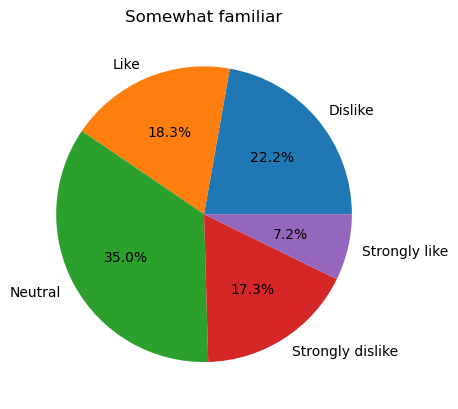

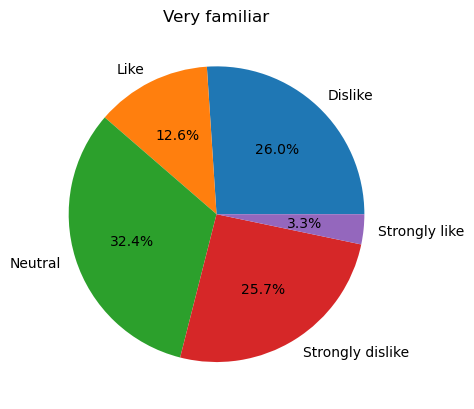

In [3]:
count = df.groupby(['Familiarity', 'Affinity']).size()

# Iterate over unique values in the first index
for familiarity in count.index.get_level_values(0).unique():

    if familiarity == 'Unfamiliar':
        continue

    # Filter the count variable for the current familiarity value
    familiarity_count = count.loc[familiarity]
    
    # Plot a pie chart for the current familiarity value
    plt.figure()
    plt.pie(familiarity_count, labels=familiarity_count.index, autopct='%1.1f%%')
    plt.title(familiarity)
    plt.show()


# Okay so people do not like us, especially as they get to know us more... 

# Lets change public perception by releasing a new, well researched, product targeting the haters. Let's see who hates us the most.

In [4]:
familar_df = df[df['Affinity'] != 'Neutral' ]
familar_df = familar_df.replace("Strongly dislike", "Dislike").replace("Strongly like", "Like")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

familar_df = familar_df[['Affinity','Age', 'Gender', 'Income Quintile', 'Race and Ethnicity', 'Region','Familiarity']]

# Perform one-hot encoding for categorical variables
data_encoded = pd.get_dummies(familar_df, columns=['Region','Age','Gender','Income Quintile','Race and Ethnicity','Familiarity'])  # Add other categorical variables as needed

X = data_encoded.drop(['Affinity'], axis=1)  # Independent variables

y = data_encoded['Affinity']  # Dependent variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit logistic regression model
model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

# Predict product preferences on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Print the coefficients to see the impact of each independent variable
coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_[0]
})
sorted_coefficients = coefficients.sort_values(by='Coefficient')
display(sorted_coefficients)


              precision    recall  f1-score   support

     Dislike       0.91      0.92      0.92       461
        Like       0.84      0.82      0.83       228

    accuracy                           0.89       689
   macro avg       0.88      0.87      0.87       689
weighted avg       0.89      0.89      0.89       689



,Variable,Coefficient
1,Region_Northeast,-2.031095
4,Age_15-24,-1.876005
11,Income Quintile_1,-1.869498
20,Race and Ethnicity_Other,-1.093337
12,Income Quintile_2,-1.048428
8,Gender_Female,-0.748641
5,Age_25-54,-0.525298
0,Region_Midwest,-0.498847
16,Race and Ethnicity_Asian,-0.476721
22,Familiarity_Very familiar,-0.216962


# Okay we are looking for the most negative values in this list of coefficients, these correspond to a negative correlation between affinity and the respective variable.

# It looks like young poor people aged 15-24 from the North East dislike our products the most. Lets find what news channel they listen to the most so we can best promote our product.

In [6]:
filtered_df = df[(df['Age'] == '15-24') & (df['Region'] == 'Northeast') & (df['Income Quintile'] == 1)]

channel_columns = ['Channel: WXP', 'Channel: RCQ', 'Channel: MegaNews', 'Channel: The Springfield Times', 'Channel: The Springfield Journal', 'Channel: The Springfield Post', 'Channel: The Franklin Burgher', 'Channel: GolfMAX', 'Channel: Sloth Magazine', 'Channel: GlitzNGlam', 'Channel: Cooking with Kevin', 'Channel: The Coffee Channel']
channel_listens = filtered_df[channel_columns].sum()
most_listened_channel = channel_listens.sort_values(ascending=False)
display(most_listened_channel)
print("The most listened to channel is:", most_listened_channel.index[0])


Channel: Sloth Magazine             YesYesYesYesNoNoNoYesYesNoNoNoYesNoNoNoNoNoNoN...
Channel: The Springfield Post       YesNoNoYesNoNoNoYesYesNoNoYesYesNoYesYesNoNoNo...
Channel: The Franklin Burgher       YesNoNoNoYesNoYesNoNoNoNoNoNoYesNoNoNoYesYesNo...
Channel: Cooking with Kevin         NoYesYesYesYesNoYesYesYesNoYesNoNoNoNoNoNoYesY...
Channel: The Springfield Times      NoYesYesNoNoYesYesNoNoYesYesNoNoNoNoNoYesNoNoN...
Channel: GolfMAX                    NoYesYesNoNoYesNoYesNoNoYesYesNoYesYesYesNoNoN...
Channel: GlitzNGlam                 NoYesNoNoYesNoYesNoNoYesNoNoNoNoNoYesYesYesNoN...
Channel: The Coffee Channel         NoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoN...
Channel: MegaNews                   NoNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoN...
Channel: RCQ                        NoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoN...
Channel: The Springfield Journal    NoNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoYesYesNoNoNo...
Channel: WXP                        NoNoNoNoNoNoNoNoNo

The most listened to channel is: Channel: Sloth Magazine
